In [312]:
import pandas as pd
all_shots = pd.read_csv("shots.csv") # original dataset

# Convert shot type to numeric shot value
all_shots["SHOT_VALUE"] = all_shots["SHOT_TYPE"].apply(lambda x: 3 if "3PT" in x else 2)

all_shots = all_shots.drop(columns=[], errors = 'ignore')

# Removing variables which won't be included in the project
# The following are either redundant, unreleated or overcomplicate the interpretability

cols_to_drop = [
    "GRID_TYPE",
    "SHOT_ATTEMPTED_FLAG",
    "PLAYER_ID", "TEAM_ID", "GAME_ID", "GAME_EVENT_ID",
    "EVENT_TYPE", "SHOT_TYPE",
    "GAME_DATE", "HTM","VTM",
    "LOC_X","LOC_Y", "SHOT_DISTANCE",
    "PERIOD", "MINUTES_REMAINING", "SECONDS_REMAINING"
]

# COMBINES THREE SHOT DESCRIPTORS INTO ONE
all_shots_zones_comb = all_shots.copy()
all_shots_zones_comb['SHOT_ZONE'] = all_shots_zones_comb['SHOT_ZONE_BASIC'] + " - " + all_shots_zones_comb['SHOT_ZONE_AREA'] + " - " + all_shots_zones_comb['SHOT_ZONE_RANGE']
all_shots_zones_comb = all_shots_zones_comb.drop(columns=["SHOT_ZONE_BASIC","SHOT_ZONE_AREA","SHOT_ZONE_RANGE"], errors = 'ignore')

# Remove backcourt shots
all_shots_zones_comb = all_shots_zones_comb[~all_shots_zones_comb["SHOT_ZONE"].str.contains("Back Court")]


zone_counts = all_shots_zones_comb["SHOT_ZONE"].value_counts()
zone_percent = zone_counts / zone_counts.sum() * 100

for zone, count in zone_counts.items():
    pct = zone_percent[zone]
    print(f"{zone}: {count}  ({pct:.2f}%)")

Restricted Area - Center(C) - Less Than 8 ft.: 66762  (32.56%)
In The Paint (Non-RA) - Center(C) - Less Than 8 ft.: 19173  (9.35%)
Above the Break 3 - Left Side Center(LC) - 24+ ft.: 16458  (8.03%)
Above the Break 3 - Right Side Center(RC) - 24+ ft.: 15660  (7.64%)
Above the Break 3 - Center(C) - 24+ ft.: 10785  (5.26%)
Mid-Range - Right Side Center(RC) - 16-24 ft.: 8028  (3.92%)
Left Corner 3 - Left Side(L) - 24+ ft.: 7759  (3.78%)
Mid-Range - Left Side Center(LC) - 16-24 ft.: 7635  (3.72%)
Mid-Range - Right Side(R) - 8-16 ft.: 7552  (3.68%)
Mid-Range - Left Side(L) - 8-16 ft.: 7544  (3.68%)
Right Corner 3 - Right Side(R) - 24+ ft.: 7276  (3.55%)
Mid-Range - Center(C) - 16-24 ft.: 7214  (3.52%)
In The Paint (Non-RA) - Center(C) - 8-16 ft.: 6756  (3.29%)
Mid-Range - Left Side(L) - 16-24 ft.: 5383  (2.63%)
Mid-Range - Right Side(R) - 16-24 ft.: 4869  (2.37%)
Mid-Range - Center(C) - 8-16 ft.: 2228  (1.09%)
In The Paint (Non-RA) - Left Side(L) - 8-16 ft.: 2065  (1.01%)
In The Paint (Non-R


================== MODEL: ALL SHOTS ==================
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
{'xgb__subsample': 0.5, 'xgb__n_estimators': 1000, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.5}


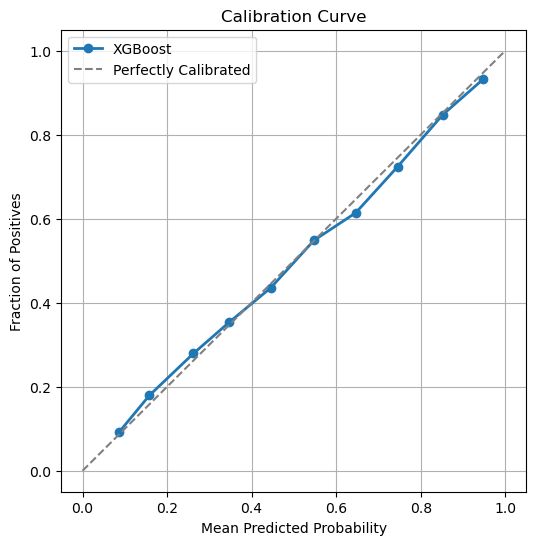


Predicted Overall Shot Success: 0.4546323121
Actual Overall Shot Success: 0.4536100071

Accuracy: 0.654 | F1 Score: 0.557 | Precision: 0.665 | Recall: 0.480
Log Loss: 0.6213 
Brier Score: 0.2167 
AUC-ROC: 0.693 
Calibration curve indicates probability reliability.
Points on diagonal = well-calibrated; above = underestimates; below = overestimates.


In [348]:
import importlib
import XGModel
importlib.reload(XGModel)
from XGModel import train_xgb_tuned, make_team_ranking_report

# --------------------------
# DATA & FEATURES
# --------------------------
features = [
    "PLAYER_NAME", "TEAM_NAME", 
    "ACTION_TYPE", "SHOT_ZONE"
]

target = "SHOT_MADE_FLAG"

# --------------------------
# PARAM GRID (for hyperparameter tuning)
# --------------------------
param_grid = {
    "xgb__n_estimators": [100, 250, 500, 750, 1000],
    "xgb__max_depth": [3, 5, 8, 10, 12],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0]
}

# --------------------------
# Train model on ALL shots 
# --------------------------
print("\n================== MODEL: ALL SHOTS ==================")
(
    best_all,
    X_all_test,
    y_all_test,
    proba_all,
    acc_all,
    f1_all,
    precision_all,
    recall_all,
    log_all,
    br_all,
    auc_all,
    pred_all,
    actual_all
) = train_xgb_tuned(
    shots_all, features, target, param_grid
)

In [349]:
make_team_ranking_report(shots_all, features=features, model=best_all)


================ TEAM PERFORMANCE TABLE ================
                 TEAM_NAME  Accuracy      F1     AUC  LogLoss   Brier
28      Washington Wizards    0.7348  0.6826  0.7933   0.5449  0.1827
4       Philadelphia 76ers    0.7277  0.6464  0.7790   0.5512  0.1858
27      Los Angeles Lakers    0.7015  0.5673  0.7307   0.5861  0.2004
15    New Orleans Pelicans    0.6932  0.6122  0.7475   0.5861  0.2008
16         Milwaukee Bucks    0.6913  0.6211  0.7527   0.5786  0.1986
3    Golden State Warriors    0.6877  0.6505  0.7412   0.5922  0.2040
26          Boston Celtics    0.6811  0.5784  0.7283   0.5959  0.2054
18               Utah Jazz    0.6763  0.5889  0.7222   0.6016  0.2082
21        Sacramento Kings    0.6746  0.5957  0.7278   0.6003  0.2075
1   Minnesota Timberwolves    0.6737  0.6051  0.7309   0.5976  0.2066
22         Detroit Pistons    0.6729  0.5634  0.7185   0.6055  0.2094
2             Phoenix Suns    0.6689  0.5422  0.7062   0.6093  0.2113
19       Charlotte Hornets    0.


================== MODEL: Wizards SHOTS ==================
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
{'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.75}


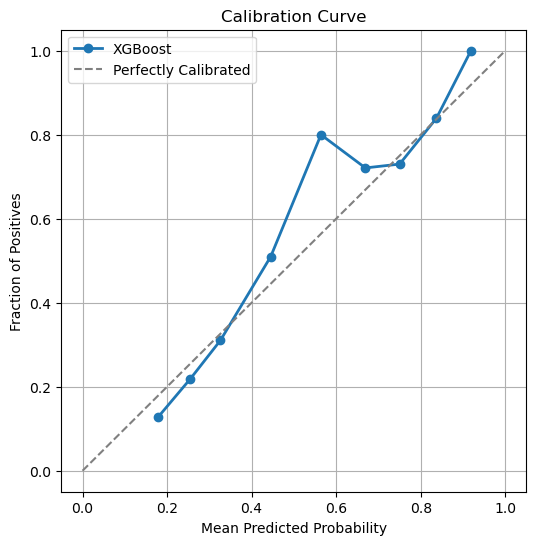


Predicted Overall Shot Success: 0.4714555740
Actual Overall Shot Success: 0.4618291761

Accuracy: 0.738 | F1 Score: 0.687 | Precision: 0.765 | Recall: 0.624
Log Loss: 0.5593 
Brier Score: 0.1878 
AUC-ROC: 0.778 
Calibration curve indicates probability reliability.
Points on diagonal = well-calibrated; above = underestimates; below = overestimates.


In [350]:
wiz = shots_all[shots_all["TEAM_NAME"] == "Washington Wizards"].copy()

print("\n================== MODEL: Wizards SHOTS ==================")
(
    best_wiz,
    X_wiz_test,
    y_wiz_test,
    proba_wiz,
    acc_wiz,
    f1_wiz,
    precision_wiz,
    recall_wiz,
    log_wiz,
    br_wiz,
    auc_wiz,
    pred_wiz,
    actual_wiz
) = train_xgb_tuned(
    wiz, features, target, param_grid
)


In [354]:
import pandas as pd
import numpy as np

# ----------------------------
# Predict probability for shots
# ----------------------------
X_all = shots_all[features]
shots_all["xP_prob"] = best_all.predict_proba(X_all)[:, 1]
shots_all["xP"] = shots_all["xP_prob"] * shots_all["SHOT_VALUE"]
shots_all["y_pred"] = (shots_all["xP_prob"] >= 0.5).astype(int)
shots_all["actual_points"] = shots_all["SHOT_VALUE"] * shots_all["SHOT_MADE_FLAG"]

# ----------------------------
# Filter Wizards
# ----------------------------
wiz = shots_all[shots_all["TEAM_NAME"] == "Washington Wizards"].copy()
shots_all["correct"] = (shots_all["y_pred"] == shots_all["SHOT_MADE_FLAG"]).astype(int)

# ----------------------------
# Group by PLAYER × ZONE × ACTION
# ----------------------------
player_zone_action = wiz.groupby(["PLAYER_NAME", "SHOT_ZONE", "ACTION_TYPE"]).agg(
    expected_points_player_zone_action=("xP", "mean"),
    actual_points_player_zone_action=("actual_points", "mean"),
    prop_correct_player_zone_action=("y_pred", 
        lambda s: np.mean(s == shots_all.loc[s.index, "SHOT_MADE_FLAG"])
    ),
    true_pct_player_zone_action=("SHOT_MADE_FLAG", "mean"),
    n_shots_player_zone_action=("SHOT_MADE_FLAG", "count")
).reset_index()

# ----------------------------
# Group by PLAYER × ZONE 
# ----------------------------
player_zone = wiz.groupby(["PLAYER_NAME", "SHOT_ZONE"]).agg(
    expected_points_player_zone=("xP", "mean"),
    actual_points_player_zone=("actual_points", "mean"),
    prop_correct_player_zone=("y_pred", 
        lambda s: np.mean(s == shots_all.loc[s.index, "SHOT_MADE_FLAG"])
    ),
    true_pct_player_zone=("SHOT_MADE_FLAG", "mean"),
    n_shots_player_zone=("SHOT_MADE_FLAG", "count")
).reset_index()

# Merge into table
player_zone_action = player_zone_action.merge(player_zone, on=["PLAYER_NAME", "SHOT_ZONE"], how="left")


# ----------------------------
# Rearrange columns
# ----------------------------
cols_ordered = [
    # identifiers
    "PLAYER_NAME", "SHOT_ZONE", "ACTION_TYPE",
    
    # shot frequency 
    "n_shots_player_zone_action", 

    # Useful for comparing how many correct predictions our model makes
    "prop_correct_player_zone_action", 

    # Having a player's true shooting pct from a zone on the court is quite common in NBA
        # advantage of our model is that our prediction includes shot type
    # We will use the maximum of this true percentage and 1-true percentage to get our 'baseline' 
        # or the probability you'd end up guessing correctly if randomly guessing no or yes (based on which one is advantageous) 
    "true_pct_player_zone", 

    # expected points
    "expected_points_player_zone_action",  

    # True points 
    "actual_points_player_zone_action"  
]

player_zone_action = player_zone_action[cols_ordered]

# ----------------------------
# Filter by prediction accuracy and sample size
# ----------------------------

# Baseline: naive predictor that always chooses the most frequent outcome (all makes or all misses) 
# based on overall success probability, here, considering historical averages of a player shooting from a given zone
baseline = np.maximum(player_zone_action["true_pct_player_zone"], 1 - player_zone_action["true_pct_player_zone"])
                
# Keep rows where the model is better than baseline
player_zone_action = player_zone_action[player_zone_action["prop_correct_player_zone_action"] > baseline]

# Keep only rows where the exact shot has been take 20+ times
player_zone_action = player_zone_action.loc[
    player_zone_action["n_shots_player_zone_action"] >= 20
]

# ----------------------------
# Sort by actual difference vs expected 
# ----------------------------
player_zone_action = (
    player_zone_action
    .drop(columns=["true_pct_player_zone"])
    .sort_values(by="expected_points_player_zone_action", ascending=False)
    .reset_index(drop=True)
)

player_zone_action["prop_correct_player_zone_action"] = (player_zone_action["prop_correct_player_zone_action"]
    .mul(100)
    .round(1)
    .astype(str)
    + "%")

player_zone_action = (
    player_zone_action
        .rename(columns={
            "n_shots_player_zone_action": "# of shots",
            "actual_points_player_zone_action": "true avg pts",
            "expected_points_player_zone_action": "expected pts",
            "prop_correct_player_zone_action": "% correct predictions"
        })
        .sort_values(by="expected pts", ascending=False)
        .reset_index(drop=True)
)
# ----------------------------
# Display / save
# ----------------------------
print("\n===== Wizards Shot Analysis vs League =====")
player_zone_action.to_csv("wiz_full_analysis.csv", index=False)
print(player_zone_action)


===== Wizards Shot Analysis vs League =====
        PLAYER_NAME                                          SHOT_ZONE  \
0     Marcin Gortat      Restricted Area - Center(C) - Less Than 8 ft.   
1         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
2              Nene      Restricted Area - Center(C) - Less Than 8 ft.   
3    Ramon Sessions      Restricted Area - Center(C) - Less Than 8 ft.   
4      Bradley Beal      Restricted Area - Center(C) - Less Than 8 ft.   
5     Marcin Gortat      Restricted Area - Center(C) - Less Than 8 ft.   
6         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
7    Ramon Sessions      Restricted Area - Center(C) - Less Than 8 ft.   
8         John Wall       Mid-Range - Left Side Center(LC) - 16-24 ft.   
9         John Wall      Restricted Area - Center(C) - Less Than 8 ft.   
10        John Wall                  Mid-Range - Center(C) - 16-24 ft.   
11        John Wall      Mid-Range - Right Side Center(RC) - 16-24 

In [320]:
p =  0.4618291761 # league average
baseline_log_loss = - (p * np.log(p) + (1-p) * np.log(1-p))
print(baseline_log_loss)

0.6902303198351483


In [321]:
# NEED TO ADD BASELINES TO PROJECT

In [322]:
p1 =  0.4536100071 # league average
baseline_log_loss = - (p1 * np.log(p1) + (1-p1) * np.log(1-p1))
print(baseline_log_loss)

0.6888369213310561
